In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.cluster.hierarchy import linkage, fcluster
from collections import defaultdict
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform

In [3]:
# Baixar dados
tickers = [
    'AMD', 'MSFT', 'IBM', 'INTC', 'QCOM', 'ARM', 'STM', 'ADI', 'TSM', 'GOOGL', 'AAPL', 
    'AMZN', 'JPM', 'ORCL', 'UBER', 'LYFT', 'HPQ', 'SHOP', 'SNAP', 'DOCU', 'ZM', 'SPOT', 
    'OKTA', 'DDOG', 'EA', 'TTWO', 'CDNS', 'ANSS', 'SNPS', 'FTNT', 'CHKP', 'PANW', 'ZS', 
    'CRWD', 'NET', 'KO', 'PEP','NVDA', 'TXN', 'MRVL', 'BIDU', 'META', 'NFLX', 'PYPL',
    'PLTR', 'ASML', 'MU', 'NXPI', 'LRCX', 'AMAT', 'KLAC', 'TER', 'INTU', 'NOW',
    'CRM', 'ADBE', 'QCOM', 'AVGO', 'TXG', 'MCHP', 'ADI', 'SWKS', 'QRVO', 'LRCX',
]

start_test = "2018-01-01"
end_test = "2025-01-01"
data = yf.download(tickers, start=start_test, end=end_test)['Close']
data = data.dropna(axis=1, thresh=int(len(data) * 0.9))  # opcional

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  61 of 61 completed


In [4]:
# Parâmetros do rolling
window = 180  # dias
step = 30
threshold = 1.5

rolling_pairs = defaultdict(list)

In [5]:
for start in range(0, len(data) - window, step):
    end = start + window
    window_data = data.iloc[start:end]
    returns = window_data.pct_change(fill_method=None).dropna()
    
    if returns.shape[0] < 10:  # skip janelas muito pequenas
        continue

    if np.abs(returns).max().max() > 0.5:  # descarta janelas com retornos extremos
        continue  # descarta pares fracos

    # Matriz de distâncias
    corr_matrix = returns.corr()
    distance_matrix = np.sqrt(2 * (1 - corr_matrix))
    linked = linkage(squareform(distance_matrix), method='ward')
    
    # Clusterização
    clusters = fcluster(linked, threshold, criterion='distance')
    cluster_labels = pd.Series(clusters, index=returns.columns)

    # Guardar pares por cluster
    for cluster_id in np.unique(clusters):
        cluster_stocks = cluster_labels[cluster_labels == cluster_id].index.tolist()
        if len(cluster_stocks) > 1:
            pairs = [(cluster_stocks[i], cluster_stocks[j])
                     for i in range(len(cluster_stocks))
                     for j in range(i+1, len(cluster_stocks))]
            for pair in pairs:
                rolling_pairs[pair].append((start, end))  # Guardar a janela onde apareceu

unique_pairs = []
seen = set()
for pair, windows in rolling_pairs.items():
    if len(windows) > 1:  # apenas pares que apareceram em mais de uma janela
        unique_pairs.append(pair)
        seen.add(pair)

rolling_pairs = {pair: windows for pair, windows in rolling_pairs.items() if pair in seen} # Filtrar pares únicos

# Exibir os pares mais persistentes
pair_counts = {pair: len(windows) for pair, windows in rolling_pairs.items()}
top_pairs = sorted(pair_counts.items(), key=lambda x: x[1], reverse=True)

print("\nTop pares persistentes ao longo do tempo:")
for pair, count in top_pairs[:10]:
    print(f"{pair}: apareceu em {count} janelas")



Top pares persistentes ao longo do tempo:
('CDNS', 'SNPS'): apareceu em 47 janelas
('EA', 'TTWO'): apareceu em 47 janelas
('AMAT', 'ASML'): apareceu em 47 janelas
('AMAT', 'KLAC'): apareceu em 47 janelas
('AMAT', 'LRCX'): apareceu em 47 janelas
('AMAT', 'MU'): apareceu em 47 janelas
('ASML', 'KLAC'): apareceu em 47 janelas
('ASML', 'LRCX'): apareceu em 47 janelas
('ASML', 'MU'): apareceu em 47 janelas
('KLAC', 'LRCX'): apareceu em 47 janelas


🧪 Teste de Cointegração Johansen para Pares
📌 Porquê usar Johansen?

    O ADF testa se o spread (diferença) é estacionário, mas assume que já conhecemos a combinação linear.

    O Johansen testa diretamente cointegração entre as séries e pode identificar o vetor cointegrante.


In [6]:
import yfinance as yf
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import numpy as np
import matplotlib.pyplot as plt

def johansen_test(pair, data):

    stock1, stock2 = pair
    prices1 = data[stock1].dropna()
    prices2 = data[stock2].dropna()

    # Alinhar os dados
    data = pd.concat([prices1, prices2], axis=1).dropna()
    data.columns = [stock1, stock2]

    log_prices = np.log(data)
    result = coint_johansen(log_prices, det_order=0, k_ar_diff=1)

    trace_stat = result.lr1[0]      # Statistic for r = 0
    crit_05 = result.cvt[0, 1]      # Critical value at 5%
    crit_10 = result.cvt[0, 2]      # Critical value at 10%

    if trace_stat > crit_05:
        print(f"Par cointegrado: {stock1} - {stock2} (Trace statistic: {trace_stat:.4f}, Critical value 5%: {crit_05:.4f})")
        return True
    elif trace_stat > crit_10:
        print(f"AVISO: Par cointegrado (10%): {stock1} - {stock2} (Trace statistic: {trace_stat:.4f}, Critical value 10%: {crit_10:.4f})")
        return True
    else:
        print(f"Par não cointegrado: {stock1} - {stock2} (Trace statistic: {trace_stat:.4f}, Critical value 5%: {crit_05:.4f})")
        return False


In [7]:
def engle_granger_test(pair, data):
    stock1, stock2 = pair
    prices1 = data[stock1].dropna()
    prices2 = data[stock2].dropna()
    # Alinhar os dados
    data = pd.concat([prices1, prices2], axis=1).dropna()
    data.columns = [stock1, stock2]

    y = np.log(data[stock1])
    x = np.log(data[stock2])
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    residuals = model.resid

    adf_stat, p_value, *_ = adfuller(residuals)
    if p_value < 0.05:
        print(f"Par cointegrado: {stock1} - {stock2} (ADF statistic: {adf_stat:.4f}, p-value: {p_value:.4f})")
        return True
    elif p_value < 0.1:
        print(f"AVISO: Par cointegrado (p_value < 0.1): {stock1} - {stock2} (ADF statistic: {adf_stat:.4f}, p-value: {p_value:.4f})")
        return True
    else:
        print(f"Par não cointegrado: {stock1} - {stock2} (ADF statistic: {adf_stat:.4f}, p-value: {p_value:.4f})")
        return False

In [8]:
def calculate_metrics(pair, data):
    stock1, stock2 = pair
    prices1 = data[stock1].dropna()
    prices2 = data[stock2].dropna()
    # Alinhar os dados
    df = pd.concat([prices1, prices2], axis=1).dropna()
    df.columns = [stock1, stock2]

    # Regressão para definir spread (linear hedge ratio)
    X = add_constant(df[stock2])
    model = OLS(df[stock1], X).fit()
    hedge_ratio = model.params[stock2]

    spread = df[stock1] - hedge_ratio * df[stock2]
    spread.name = "spread"

    # Half-life
    spread_lag = spread.shift(1).dropna()
    delta_spread = spread.diff().dropna()
    spread_lag = spread_lag.loc[delta_spread.index]

    model = OLS(delta_spread, add_constant(spread_lag)).fit()
    halflife = -np.log(2) / model.params.iloc[1]

    # Correlação
    correlation = df[stock1].corr(df[stock2])

    # Z-score vol
    zscore = (spread - spread.mean()) / spread.std()
    zscore_vol = np.std(zscore)

    return {
        'pair': pair,
        'half_life': halflife,
        'correlation': correlation,
        'zscore_vol': zscore_vol
    }

In [9]:
def plot_spread(pair, data):
    stock1, stock2 = pair
    prices1 = data[stock1].dropna()
    prices2 = data[stock2].dropna()
    # Alinhar os dados
    df = pd.concat([prices1, prices2], axis=1).dropna()
    df.columns = [stock1, stock2]

    # Regressão para definir spread (linear hedge ratio)
    X = add_constant(df[stock2])
    model = OLS(df[stock1], X).fit()
    hedge_ratio = model.params[stock2]

    spread = df[stock1] - hedge_ratio * df[stock2]
    spread.name = "spread"

    plt.figure(figsize=(12, 6))
    plt.plot(spread.index, spread, label='Spread', color='blue')
    plt.axhline(spread.mean(), color='red', linestyle='--', label='Mean')
    plt.axhline(spread.mean() + 2 * spread.std(), color='green', linestyle='--', label='Upper Band')
    plt.axhline(spread.mean() - 2 * spread.std(), color='orange', linestyle='--', label='Lower Band')
    plt.title(f'Spread between {pair[0]} and {pair[1]}')
    plt.legend()
    plt.show()

Par cointegrado: CDNS - SNPS (Trace statistic: 16.0132, Critical value 5%: 15.4943)
Par cointegrado: CDNS - SNPS (ADF statistic: -3.8274, p-value: 0.0026)
Par não cointegrado: EA - TTWO (Trace statistic: 12.0241, Critical value 5%: 15.4943)
AVISO: Par cointegrado (p_value < 0.1): EA - TTWO (ADF statistic: -2.6992, p-value: 0.0742)
Par não cointegrado: AMAT - ASML (Trace statistic: 15.1827, Critical value 5%: 15.4943)
Par cointegrado: AMAT - ASML (ADF statistic: -3.1056, p-value: 0.0261)
Par não cointegrado: AMAT - KLAC (Trace statistic: 7.2145, Critical value 5%: 15.4943)
Par não cointegrado: AMAT - KLAC (ADF statistic: -2.3930, p-value: 0.1437)
Par não cointegrado: AMAT - LRCX (Trace statistic: 12.5549, Critical value 5%: 15.4943)
AVISO: Par cointegrado (p_value < 0.1): AMAT - LRCX (ADF statistic: -2.5853, p-value: 0.0961)
Par não cointegrado: AMAT - MU (Trace statistic: 13.9894, Critical value 5%: 15.4943)
Par cointegrado: AMAT - MU (ADF statistic: -3.1630, p-value: 0.0222)
Par não c

,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
0,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
3,"(AMAT, LRCX)",False,True,69.905496,0.987524,0.999716,1.400577
5,"(ASML, LRCX)",False,True,67.719622,0.970526,0.999716,1.395616
2,"(AMAT, ASML)",False,True,83.972777,0.968024,0.999716,1.394008
4,"(AMAT, MU)",False,True,52.197024,0.928306,0.999716,1.384267
6,"(ASML, MU)",False,True,82.902057,0.867228,0.999716,1.363815
1,"(EA, TTWO)",False,True,79.614853,0.697300,0.999716,1.312986



Resultados detalhados e spread:
Par: ('CDNS', 'SNPS'), Half-life: 42.44, Correlation: 1.00, Z-score vol: 1.00


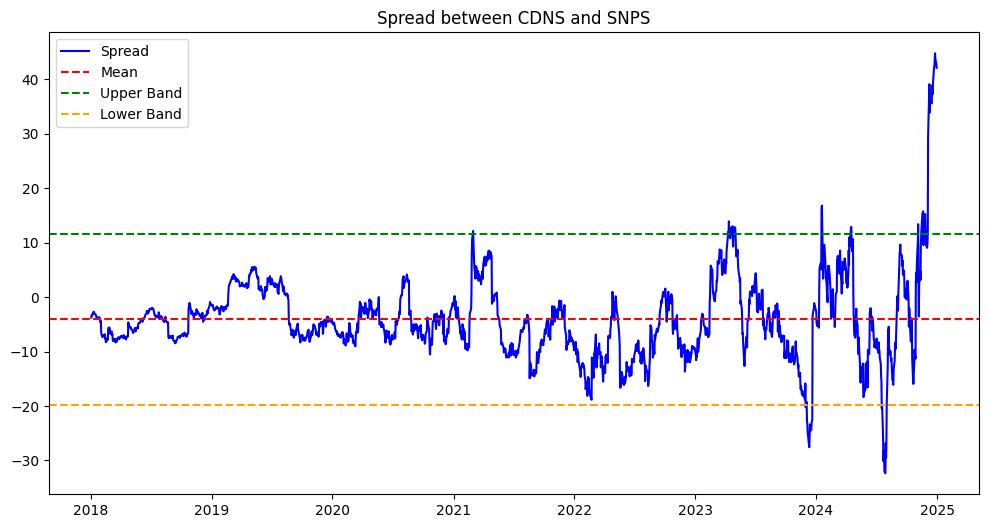

Par: ('AMAT', 'LRCX'), Half-life: 69.91, Correlation: 0.99, Z-score vol: 1.00


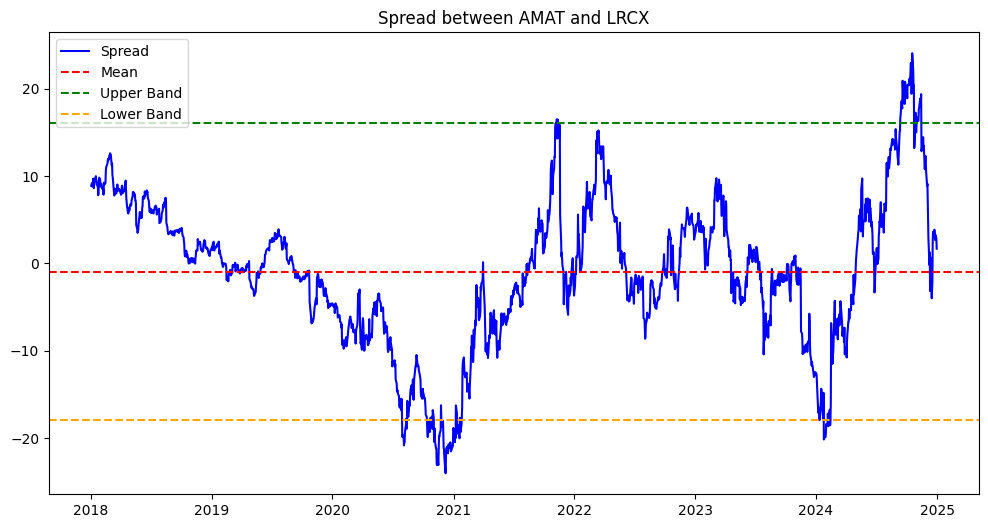

Par: ('ASML', 'LRCX'), Half-life: 67.72, Correlation: 0.97, Z-score vol: 1.00


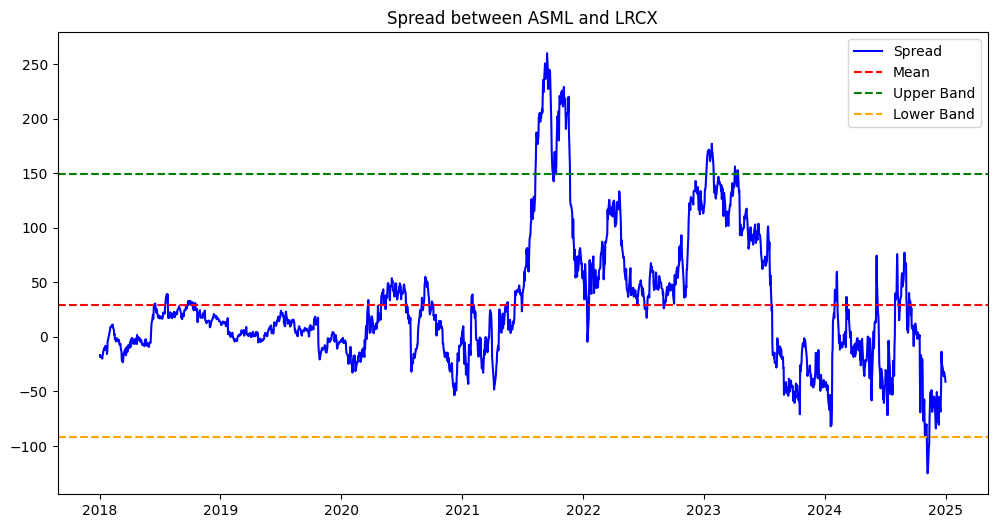

Par: ('AMAT', 'ASML'), Half-life: 83.97, Correlation: 0.97, Z-score vol: 1.00


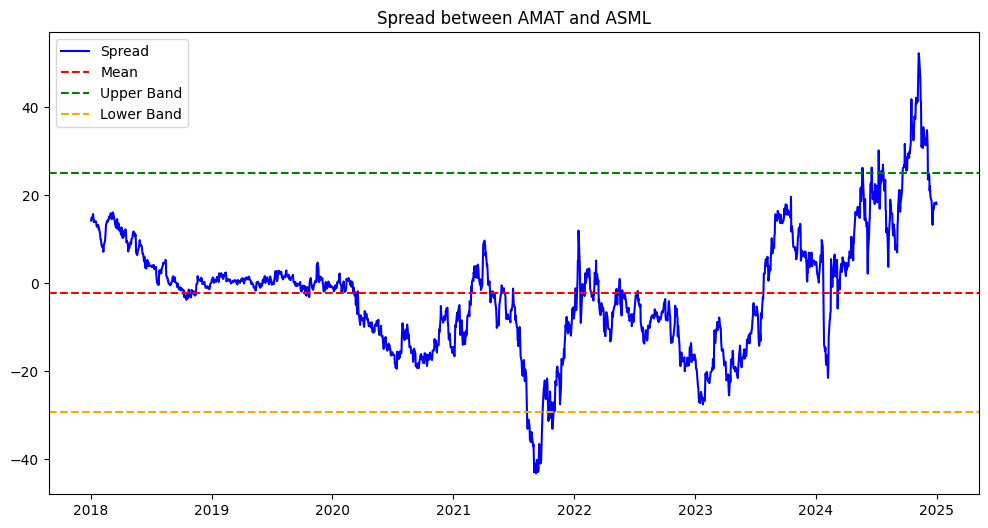

Par: ('AMAT', 'MU'), Half-life: 52.20, Correlation: 0.93, Z-score vol: 1.00


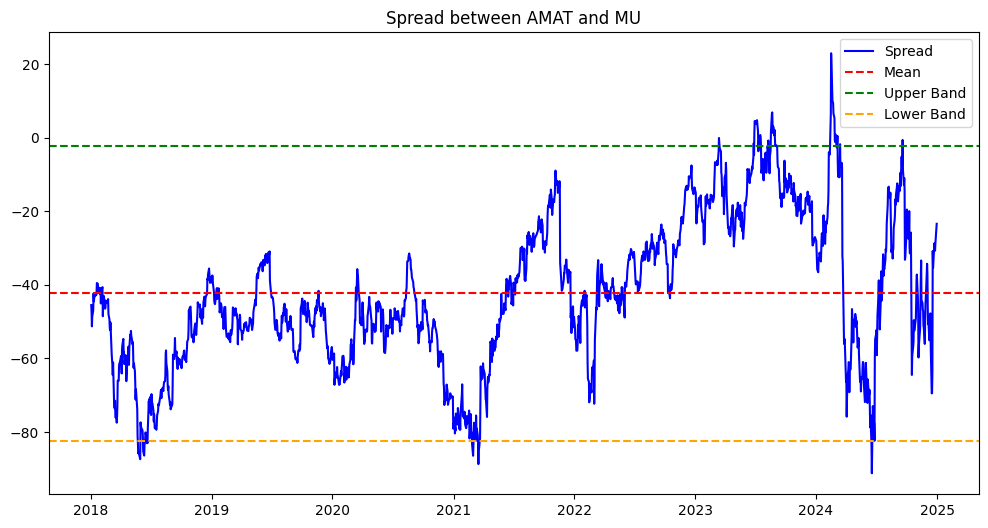

Par: ('ASML', 'MU'), Half-life: 82.90, Correlation: 0.87, Z-score vol: 1.00


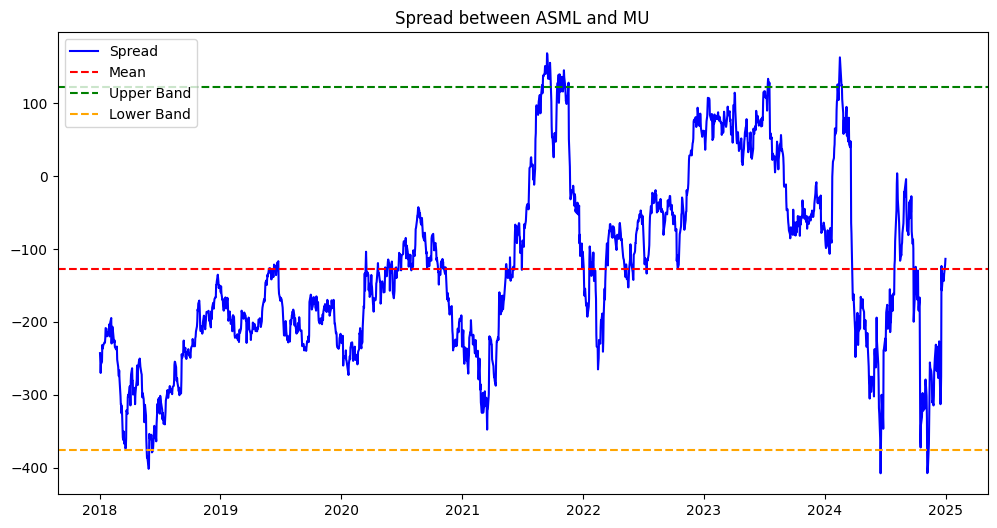

Par: ('EA', 'TTWO'), Half-life: 79.61, Correlation: 0.70, Z-score vol: 1.00


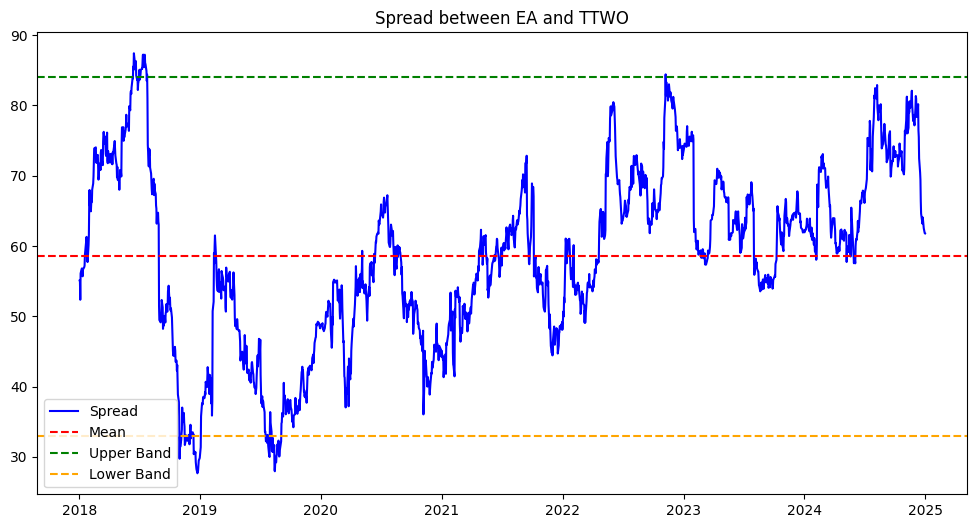

In [10]:
selected_pairs = [pair for pair, _ in top_pairs[:10]]

# --- 1. Avalia todos os pares e guarda resultados --------------------------
final_results = []      # para o ranking
pair_stats    = {}      # dicionário com tudo p/ reutilizar (plots etc.)

for pair in selected_pairs:
    j_test  = johansen_test(pair, data)
    eg_test = engle_granger_test(pair, data)
    metrics = calculate_metrics(pair, data)

    # Guarda tudo num único lugar
    pair_stats[pair] = {
        'johansen'      : j_test,
        'engle_granger' : eg_test,
        **metrics       # half_life, correlation, zscore_vol
    }

    # Só pontua se passou em pelo menos um teste
    if j_test or eg_test:
        score = (
        1.0 * int(j_test or eg_test) +
        0.3 * metrics['correlation'] +
        0.3 * (1 / (metrics['half_life'] + 1e-6)) +
        0.1 * (1 / (metrics['zscore_vol'] + 1e-6))
    )

        pair_stats[pair]['score'] = score
        final_results.append({'pair': pair, **pair_stats[pair]})

# --- 2. Cria DataFrame ordenado --------------------------------------------
results_df = (
    pd.DataFrame(final_results)
      .sort_values('score', ascending=False)
)

if results_df.empty:
    print("Nenhum par passou nos testes de cointegração.")
else:
    print("\nTop pares cointegrados encontrados:")
    display(
        results_df[['pair', 'johansen', 'engle_granger',
                    'half_life', 'correlation', 'zscore_vol', 'score']].head(10)
    )

# --- 3. Imprime métricas e plota spread só para os pares ranqueados ---------
print("\nResultados detalhados e spread:")
for pair in results_df['pair']:                 # já vem ordenado por score
    stats = pair_stats[pair]
    print(
        f"Par: {pair}, "
        f"Half-life: {stats['half_life']:.2f}, "
        f"Correlation: {stats['correlation']:.2f}, "
        f"Z-score vol: {stats['zscore_vol']:.2f}"
    )
    plot_spread(pair, data)
